# Data wrangling

In [1]:
import os
import time
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from kagglehub import KaggleDatasetAdapter

# Encode state? 
encode_state=True

# Data files
raw_data_filepath='../data/raw_disaster_data.parquet'

## 1. Download disaster data from Kaggle

In [2]:
# Load a data from disk or Kaggle if we don't already have it
if os.path.exists(raw_data_filepath):
    raw_data_df=pd.read_parquet(raw_data_filepath)

else:
    raw_data_df=kagglehub.load_dataset(
        KaggleDatasetAdapter.PANDAS,
        'headsortails/us-natural-disaster-declarations',
        'us_disaster_declarations.csv',
    )

# Check the total incident count
original_incident_count=len(raw_data_df)
print(f'{original_incident_count} total incident records')

64092 total incident records


In [3]:
raw_data_df.head().transpose()

,0,1,2,3,4
fema_declaration_string,DR-1-GA,DR-2-TX,DR-3-LA,DR-4-MI,DR-5-MT
disaster_number,1,2,3,4,5
state,GA,TX,LA,MI,MT
declaration_type,DR,DR,DR,DR,DR
declaration_date,1953-05-02T00:00:00Z,1953-05-15T00:00:00Z,1953-05-29T00:00:00Z,1953-06-02T00:00:00Z,1953-06-06T00:00:00Z
fy_declared,1953,1953,1953,1953,1953
incident_type,Tornado,Tornado,Flood,Tornado,Flood
declaration_title,Tornado,Tornado & Heavy Rainfall,Flood,Tornado,Floods
ih_program_declared,0,0,0,0,0
ia_program_declared,1,1,1,1,1


In [4]:
raw_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64092 entries, 0 to 64091
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   fema_declaration_string     64092 non-null  object
 1   disaster_number             64092 non-null  int64 
 2   state                       64092 non-null  object
 3   declaration_type            64092 non-null  object
 4   declaration_date            64092 non-null  object
 5   fy_declared                 64092 non-null  int64 
 6   incident_type               64092 non-null  object
 7   declaration_title           64092 non-null  object
 8   ih_program_declared         64092 non-null  int64 
 9   ia_program_declared         64092 non-null  int64 
 10  pa_program_declared         64092 non-null  int64 
 11  hm_program_declared         64092 non-null  int64 
 12  incident_begin_date         64092 non-null  object
 13  incident_end_date           55682 non-null  ob

In [5]:
# Save the raw data
raw_data_df.to_parquet(raw_data_filepath)

## 2. Feature selection

In [6]:
# Get only the features we are going to work with into a new dataframe
working_df=raw_data_df[['incident_begin_date','state','incident_type']].copy()

# Convert 'incident_begin_date' to month and year columns and set as index
working_df['incident_begin_date']=pd.to_datetime(working_df['incident_begin_date'])

# Fix the index
working_df.reset_index(inplace=True, drop=True)

# Check the total incident count
feature_selected_incident_count=len(working_df)
print(f'{original_incident_count} total incident records')
print(f'{feature_selected_incident_count} incidents after feature selection')

64092 total incident records
64092 incidents after feature selection


In [7]:
working_df.head()

,incident_begin_date,state,incident_type
0,1953-05-02 00:00:00+00:00,GA,Tornado
1,1953-05-15 00:00:00+00:00,TX,Tornado
2,1953-05-29 00:00:00+00:00,LA,Flood
3,1953-06-02 00:00:00+00:00,MI,Tornado
4,1953-06-06 00:00:00+00:00,MT,Flood


In [8]:
working_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64092 entries, 0 to 64091
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   incident_begin_date  64092 non-null  datetime64[ns, UTC]
 1   state                64092 non-null  object             
 2   incident_type        64092 non-null  object             
dtypes: datetime64[ns, UTC](1), object(2)
memory usage: 1.5+ MB


## 3. Incident selection & encoding

### 3.1. Subset records by incident type

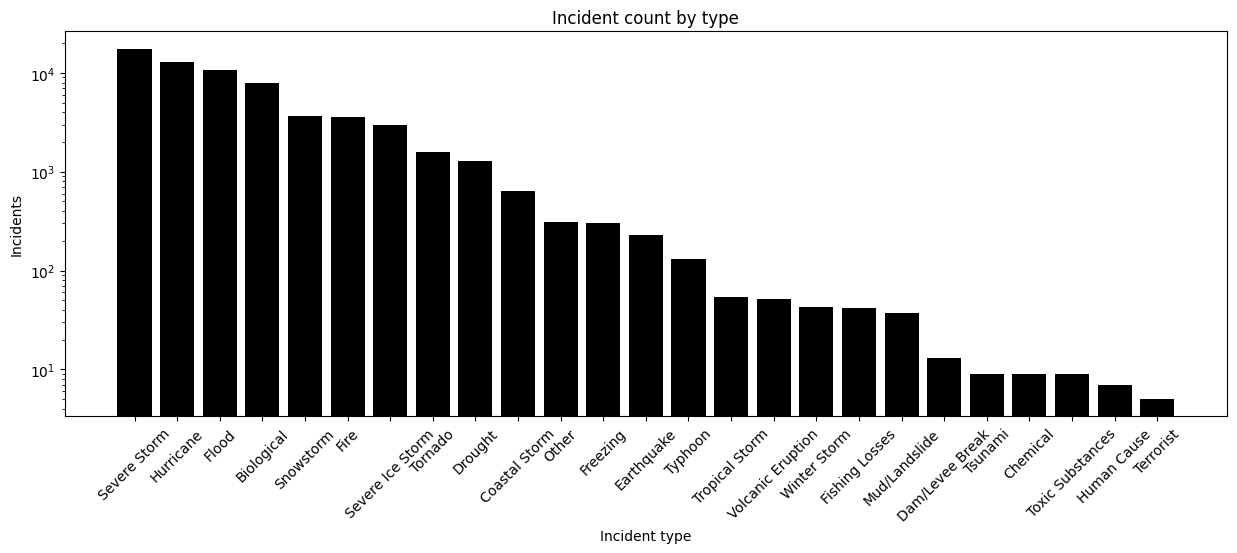

In [9]:
incident_type_counts=working_df['incident_type'].value_counts()

plt.figure(figsize=(15,5))
plt.title('Incident count by type')
plt.bar(list(range(len(incident_type_counts))), incident_type_counts, color='black')
plt.xticks(list(range(len(incident_type_counts))), incident_type_counts.index.values)
plt.xlabel('Incident type')
plt.ylabel('Incidents')
plt.yscale('log')
plt.xticks(rotation=45)
plt.show()

Looks like a few storm related incidents dominate the incident type counts. I think we can discount 'biological', that one is mostly COVID19. Let's provisionally call this a 'water incident' model and focus on the following incident types: 'Severe Storm', 'Hurricane', 'Flood', 'Coastal Storm', 'Typhoon', 'Tropical Storm'. Theses incident types are also likely to have a location specific seasonality - this is what we expect the model to be able to learn. Let's add 'Snowstorm' and 'Severe Ice Storm' and 'Freezing' as well, since these likely have the same property of location specific seasonality. I doubt there is much this dataset can do for us to predict many of the others, for example earthquakes or volcanic eruptions. One other interesting one to add could be fire, because wildfires are also seasonal in some places, but it seems like is should be in a different category from the others.

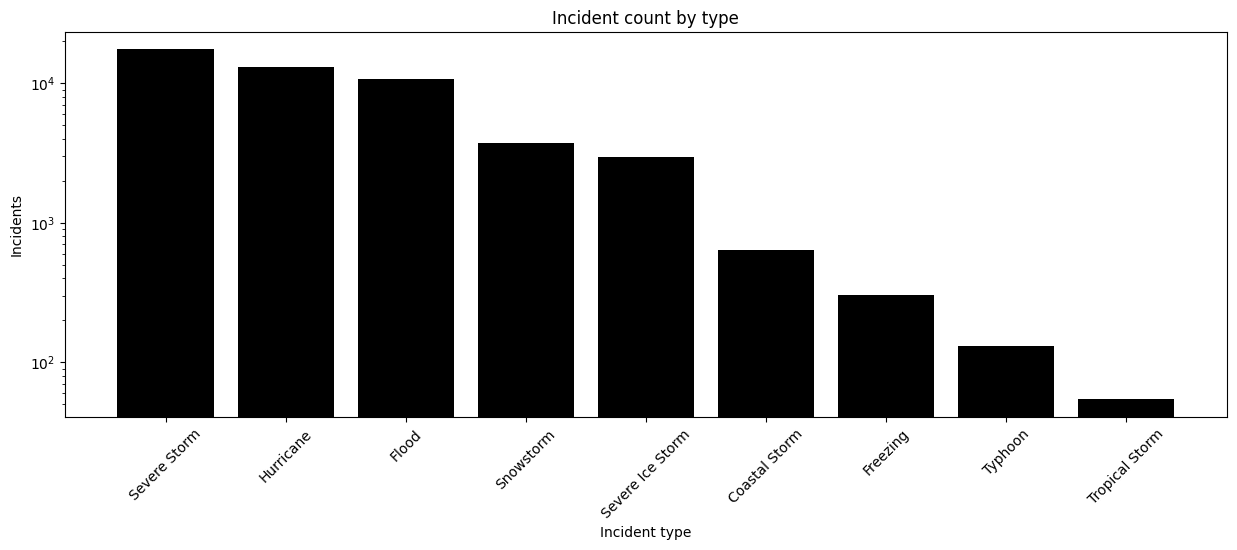

In [10]:
# Define target disaster types for summation and prediction
target_incidents=['Severe Storm', 'Hurricane', 'Flood', 'Coastal Storm', 'Typhoon', 'Tropical Storm', 'Snowstorm', 'Severe Ice Storm', 'Freezing']

# Filter rows by target incident types
working_df=working_df[working_df['incident_type'].isin(target_incidents)]

# Re-plot the incident types
incident_type_counts=working_df['incident_type'].value_counts()

plt.figure(figsize=(15,5))
plt.title('Incident count by type')
plt.bar(list(range(len(incident_type_counts))), incident_type_counts, color='black')
plt.xticks(list(range(len(incident_type_counts))), incident_type_counts.index.values)
plt.xlabel('Incident type')
plt.ylabel('Incidents')
plt.yscale('log')
plt.xticks(rotation=45)
plt.show()

### 3.2. Encode incidents

Since each row in the dataset is a single incident, nothing fancy is needed here - we can just add a new column `incidents` with a one in it.

In [11]:
# Add integer incidents
working_df['incidents']=[1] * len(working_df)

# Drop the string incident_type column
working_df.drop('incident_type', axis=1, inplace=True)

working_df.head()

,incident_begin_date,state,incidents
2,1953-05-29 00:00:00+00:00,LA,1
4,1953-06-06 00:00:00+00:00,MT,1
6,1953-06-11 00:00:00+00:00,IA,1
8,1953-06-19 00:00:00+00:00,TX,1
10,1953-10-22 00:00:00+00:00,FL,1


In [12]:
# Check the total incident count
incident_selected_incident_count=working_df['incidents'].sum()
print(f'{original_incident_count} total incident records')
print(f'{feature_selected_incident_count} incidents after feature selection')
print(f'{incident_selected_incident_count} incidents after incident encoding & selection')

64092 total incident records
64092 incidents after feature selection
48999 incidents after incident encoding & selection


## 4. State selection

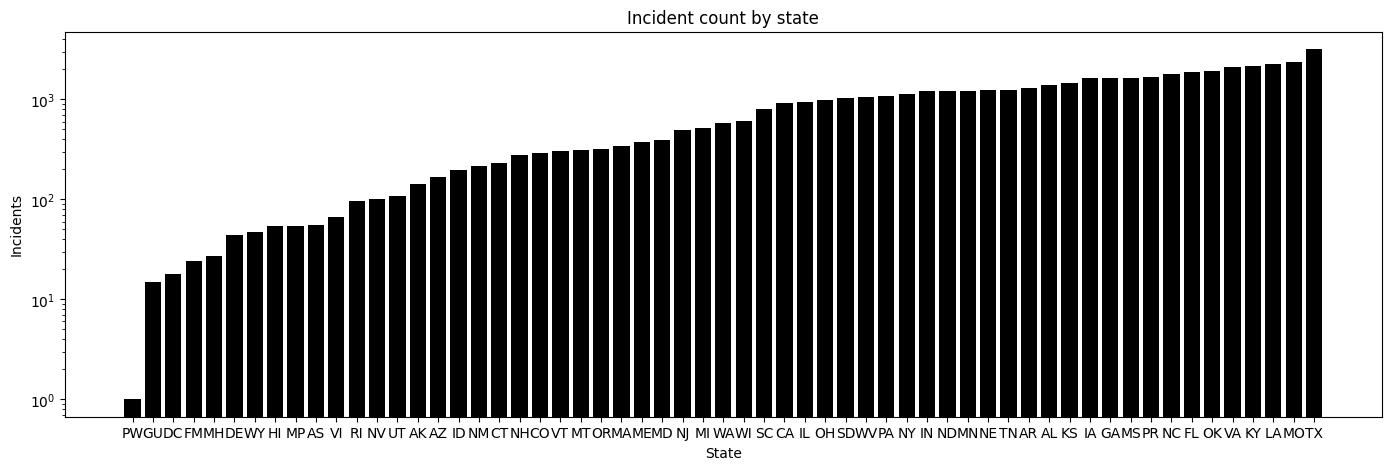

In [13]:
state_incident_counts=working_df.groupby('state')['incidents'].sum().sort_values()

plt.figure(figsize=(17,5))
plt.title('Incident count by state')
plt.bar(list(range(len(state_incident_counts))), state_incident_counts, color='black')
plt.xticks(list(range(len(state_incident_counts))), state_incident_counts.index.values)
plt.xlabel('State')
plt.ylabel('Incidents')
plt.yscale('log')
plt.show()

We have some 'states' with very low incident counts: PW, MP, FM, GU, MH and DC. Most of these are not in fact states, but territories or commonwealths, etc.:

1. PW: Palau
2. MP: Northern Mariana Islands
3. FM: Micronesia
4. GU: Guam
5. MH: Marshall Islands
6. DC: District of Columbia
7. AS: American Samoa

Let's remove those so we are focused on states only. While whe are at it, let's remove Hawaii and Alaska so we have only the continental US.

Have data for 50 states
64092 total incident records
64092 incidents after feature selection
48999 incidents after incident encoding & selection
48606 incidents after state selection


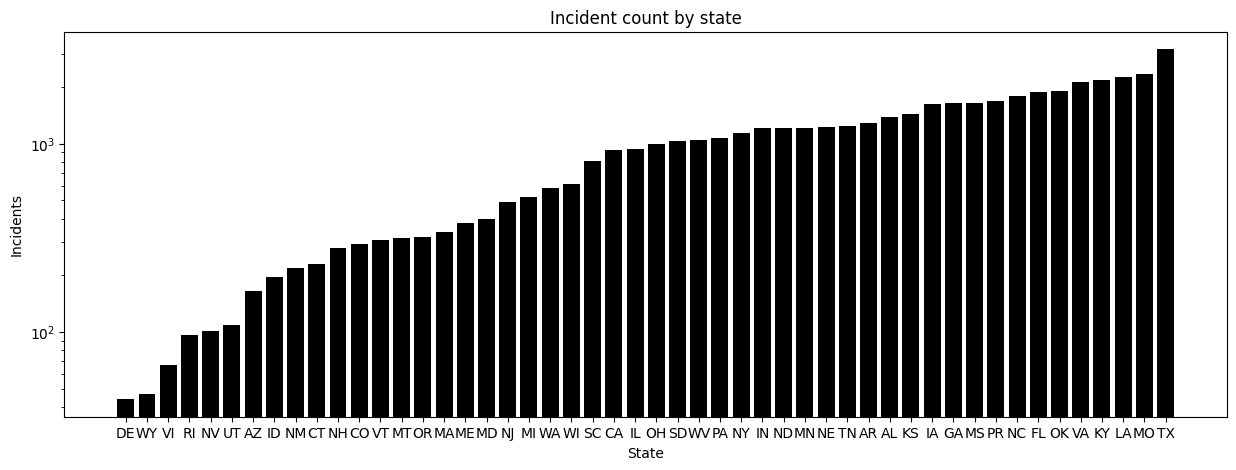

In [14]:
non_states=['PW', 'MP', 'FM', 'GU', 'MH', 'DC', 'AS', 'HI', 'AK']
working_df=working_df[~working_df['state'].isin(non_states)]
working_df.reset_index(inplace=True, drop=True)
state_incident_counts=working_df.groupby('state')['incidents'].sum().sort_values()
state_selected_incident_count=working_df['incidents'].sum()
print(f'Have data for {len(state_incident_counts)} states')
print(f'{original_incident_count} total incident records')
print(f'{feature_selected_incident_count} incidents after feature selection')
print(f'{incident_selected_incident_count} incidents after incident encoding & selection')
print(f'{state_selected_incident_count} incidents after state selection')

plt.figure(figsize=(15,5))
plt.title('Incident count by state')
plt.bar(list(range(len(state_incident_counts))), state_incident_counts, color='black')
plt.xticks(list(range(len(state_incident_counts))), state_incident_counts.index.values)
plt.xlabel('State')
plt.ylabel('Incidents')
plt.yscale('log')
plt.show()

In [15]:
working_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48606 entries, 0 to 48605
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   incident_begin_date  48606 non-null  datetime64[ns, UTC]
 1   state                48606 non-null  object             
 2   incidents            48606 non-null  int64              
dtypes: datetime64[ns, UTC](1), int64(1), object(1)
memory usage: 1.1+ MB


Now, we need to regularize the time series to a frequency of months across the span of years within each state.

## 5. Time series regularization

In [16]:
import math

def sum_months(group: pd.DataFrame) -> pd.DataFrame:
    '''Takes a yearly groupby object and sums features over months'''

    return group.resample('ME').sum()


def resample_months(group: pd.DataFrame) -> pd.DataFrame:
    '''Takes working dataframe and resamples frequency to months.
    Returns updated dataframe'''

    # Set 'incident_begin_date' as datetime axis
    group=group.set_index('incident_begin_date')

    # Make sure it's sorted
    group=group.sort_index()

    # Sum the disasters in each month by year. This removes duplicates where
    # there was more than one disaster in a month.
    group=group.groupby(group.index.year, group_keys=False).apply(sum_months)

    # Resample to monthly frequency
    group=group.resample('ME').asfreq()

    # Fill missing values with 0
    group=group.fillna(0)

    # Convert everything to int
    group=group.astype(int)

    # Reset the index, preserving the `incident_begin_date`
    group.reset_index(inplace=True, drop=False)

    return group

# Do the resampling
resampled_working_df=working_df.groupby('state', group_keys=True).apply(resample_months, include_groups=False)

# Unset the group index
resampled_working_df.reset_index(inplace=True, drop=False)
resampled_working_df.drop('level_1', axis=1, inplace=True)

# Sort by datetime
resampled_working_df = resampled_working_df.sort_values('incident_begin_date')

# Re-check disaster counts
resampled_incident_count=resampled_working_df['incidents'].sum()
print(f'{original_incident_count} total incident records')
print(f'{feature_selected_incident_count} incidents after feature selection')
print(f'{incident_selected_incident_count} incidents after incident encoding & selection')
print(f'{state_selected_incident_count} incidents after state selection')
print(f'{resampled_incident_count} after time axis resampling')

64092 total incident records
64092 incidents after feature selection
48999 incidents after incident encoding & selection
48606 incidents after state selection
48606 after time axis resampling


In [17]:
resampled_working_df.head(20)

,state,incident_begin_date,incidents
11521,LA,1953-05-31 00:00:00+00:00,1
17538,MT,1953-06-30 00:00:00+00:00,1
31393,TX,1953-06-30 00:00:00+00:00,1
11522,LA,1953-06-30 00:00:00+00:00,0
6815,IA,1953-06-30 00:00:00+00:00,1
11523,LA,1953-07-31 00:00:00+00:00,0
17539,MT,1953-07-31 00:00:00+00:00,0
6816,IA,1953-07-31 00:00:00+00:00,0
31394,TX,1953-07-31 00:00:00+00:00,0
6817,IA,1953-08-31 00:00:00+00:00,0


In [18]:
resampled_working_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37622 entries, 11521 to 3000
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   state                37622 non-null  object             
 1   incident_begin_date  37622 non-null  datetime64[ns, UTC]
 2   incidents            37622 non-null  int64              
dtypes: datetime64[ns, UTC](1), int64(1), object(1)
memory usage: 1.1+ MB


In [19]:
resampled_working_df.describe()

,incidents
count,37622.000000
mean,1.291957
std,9.449119
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,509.000000


#### 5.1. Scaled time-series heat-map

In [20]:
np.seterr(divide='ignore')
raw_incidents=resampled_working_df['incidents'].copy()
log_incidents=np.log10(resampled_working_df['incidents'])
resampled_working_df['log_incidents']=log_incidents
resampled_working_df.replace({-np.inf:np.nan}, inplace=True)
resampled_working_df.replace({0:1}, inplace=True)
resampled_working_df.replace({np.nan:0}, inplace=True)
resampled_working_df['incidents']=raw_incidents
resampled_working_df.describe()

,incidents,log_incidents
count,37622.000000,37622.000000
mean,1.291957,0.067273
std,9.449119,0.286450
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,509.000000,2.706718


In [21]:
# Pivot from long to wide and clean up
wide_resampled_working_df=pd.pivot_table(resampled_working_df, values='log_incidents', index=['incident_begin_date'], columns=['state'])
wide_resampled_working_df.fillna(value=0, inplace=True)
wide_resampled_working_df.reset_index(inplace=True, drop=True)
wide_resampled_working_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
state,,,,,,,,
AL,839.0,0.087671,0.322038,0.0,0.0,0.0,0.0,2.127105
AR,839.0,0.079240,0.318069,0.0,0.0,0.0,0.0,2.075547
AZ,839.0,0.028377,0.157985,0.0,0.0,0.0,0.0,1.278754
CA,839.0,0.074658,0.296938,0.0,0.0,0.0,0.0,1.763428
CO,839.0,0.024535,0.172291,0.0,0.0,0.0,0.0,1.806180
CT,839.0,0.030172,0.165148,0.0,0.0,0.0,0.0,1.301030
DE,839.0,0.015933,0.112753,0.0,0.0,0.0,0.0,1.000000
FL,839.0,0.098677,0.351427,0.0,0.0,0.0,0.0,2.217484
GA,839.0,0.061998,0.298669,0.0,0.0,0.0,0.0,2.502427


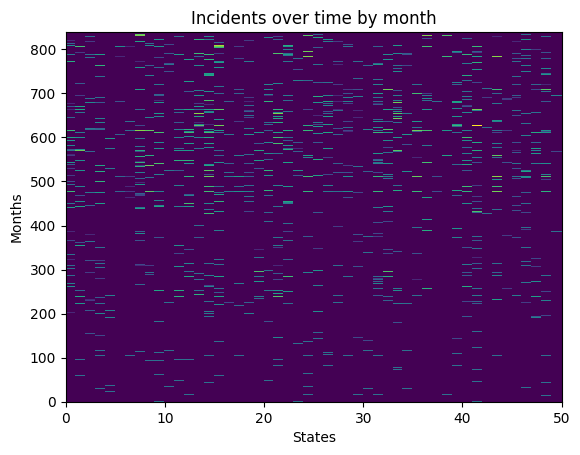

In [22]:
plt.title('Incidents over time by month')
plt.pcolor(wide_resampled_working_df)
plt.xlabel('States')
plt.ylabel('Months')
plt.show()

No too bad - once we do some tricky scaling by applying a log transformation to only the non-zero values by state we can see a good speckling of incidents over time in each state, though there does seem to be an overall increasing trend in incidents over time. Some states appear to be dominated by a single large peak or peaks. There are also some 'anomalies', where it seems like many states have incidents all in the same month. This makes sense - a large hurricane effecting many states at once for example.

#### 5.2. Scaled non-zero incident distributions

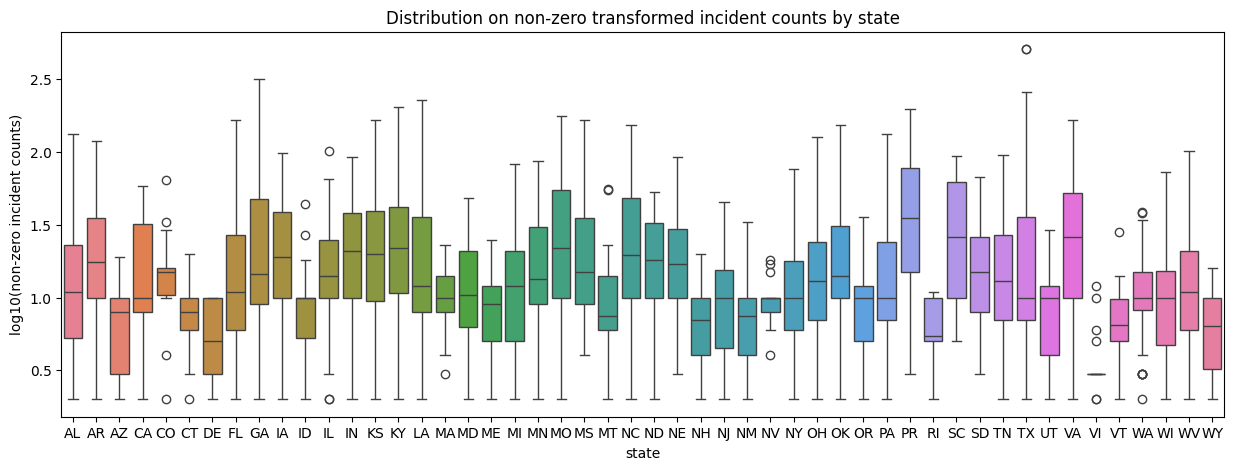

In [23]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(15, 5))
plt.title('Distribution on non-zero transformed incident counts by state')
sns.boxplot(wide_resampled_working_df.replace({0.0:np.nan}), ax=ax)
plt.ylabel('log10(non-zero incident counts)')
plt.show()

It might be interesting to cluster this data. Then we could train a model per cluster or use cluster membership as a feature. This also makes sense, since states that are near each other geographically probably have similar disaster profiles. Let's try it.

#### 5.1. Time-series clustering

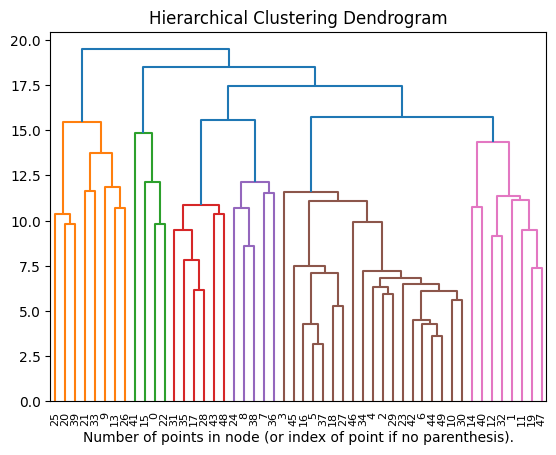

In [24]:
def plot_dendrogram(model, **kwargs):

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


# setting distance_threshold=0 ensures we compute the full tree.
model=AgglomerativeClustering(distance_threshold=0, n_clusters=None, compute_full_tree=True)
model=model.fit(wide_resampled_working_df.transpose())

plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model, color_threshold=15.5)#, truncate_mode='level', p=5)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

Looks like 6 clusters is probably about right, let's compute and then plot the clusters separately as time-series heat maps.

In [25]:
# Do the clustering with 6 clusters
model=AgglomerativeClustering(distance_threshold=None, n_clusters=6, compute_full_tree=True)
model=model.fit(wide_resampled_working_df.transpose())

# Add the cluster index as a second level to the row index
idx=pd.MultiIndex.from_tuples(list(zip(model.labels_, wide_resampled_working_df.columns)),names=['cluster', 'state'])
wide_resampled_working_df.columns=idx
wide_resampled_working_df.head()

cluster    2    1    4                        3         0  ...    1    2    4  \
state     AL   AR   AZ   CA   CO   CT   DE   FL   GA   IA  ...   TN   TX   UT   
0        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  0.0  1.0  0.0   
2        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
3        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

cluster    5    4              1    5    4  
state     VA   VI   VT   WA   WI   WV   WY  
0        0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1        0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2        0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3        0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4        0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 50 columns]

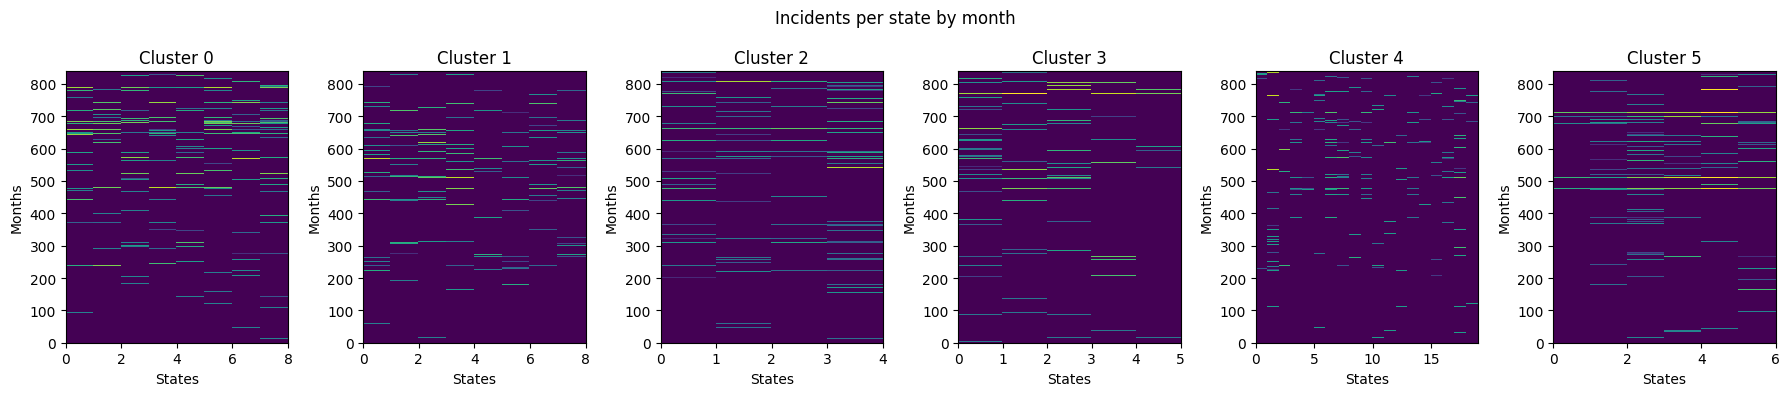

In [26]:
# Plot each cluster
clusters=wide_resampled_working_df.T.groupby(level=0)

fig, axs=plt.subplots(1,len(clusters), figsize=(3*len(clusters),4))
axs=axs.flatten()

fig.suptitle('Incidents per state by month')
i=0

for cluster, data in clusters:
    axs[i].set_title(f'Cluster {i}')
    axs[i].pcolor(data.T)
    axs[i].set_xlabel('States')
    axs[i].set_ylabel('Months')
    i+=1

plt.tight_layout()
plt.show()

This looks cool, but I'm not sure how useful it is. We could train a separate model for each cluster, or add the cluster membership as a feature.

## 6. Month encoding

In [27]:
# Extract month and year from 'incident_begin_date' and drop
resampled_working_df['year']=resampled_working_df['incident_begin_date'].dt.year.astype(int)
resampled_working_df['month']=resampled_working_df['incident_begin_date'].dt.month.astype(int)
resampled_working_df.drop('incident_begin_date', axis=1, inplace=True)

In [28]:
# Encode month with sin and cos components
resampled_working_df['month_sin'] = np.sin(2 * np.pi * resampled_working_df['month']/12.0)
resampled_working_df['month_cos'] = np.cos(2 * np.pi * resampled_working_df['month']/12.0)

In [29]:
resampled_working_df.head()

,state,incidents,log_incidents,year,month,month_sin,month_cos
11521,LA,1,1.0,1953,5,5.000000e-01,-0.866025
17538,MT,1,1.0,1953,6,1.224647e-16,-1.000000
31393,TX,1,1.0,1953,6,1.224647e-16,-1.000000
11522,LA,0,0.0,1953,6,1.224647e-16,-1.000000
6815,IA,1,1.0,1953,6,1.224647e-16,-1.000000


## 7. State encoding

In [30]:
if encode_state==True:

    # Dummy encode state
    states=pd.get_dummies(resampled_working_df['state'], dtype=int, drop_first=True)

    # Add the state dummies to the dataframe
    resampled_working_df=pd.concat([resampled_working_df, states], axis=1)

    resampled_working_df.head()

## 8. Set index

In [31]:
# Create multi-index
indexes=[
    resampled_working_df['year'].tolist(),
    resampled_working_df['state'].tolist(),
    resampled_working_df['month'].tolist()
]

index_tuples=list(zip(*indexes))
index=pd.MultiIndex.from_tuples(index_tuples, names=['year', 'state', 'month'])
resampled_working_df.set_index(index, inplace=True)
resampled_working_df.drop(['year', 'month', 'state'], axis=1, inplace=True)

In [32]:
resampled_working_df.head(20)

incidents  log_incidents     month_sin     month_cos  AR  \
year state month                                                             
1953 LA    5              1            1.0  5.000000e-01 -8.660254e-01   0   
     MT    6              1            1.0  1.224647e-16 -1.000000e+00   0   
     TX    6              1            1.0  1.224647e-16 -1.000000e+00   0   
     LA    6              0            0.0  1.224647e-16 -1.000000e+00   0   
     IA    6              1            1.0  1.224647e-16 -1.000000e+00   0   
     LA    7              0            0.0 -5.000000e-01 -8.660254e-01   0   
     MT    7              0            0.0 -5.000000e-01 -8.660254e-01   0   
     IA    7              0            0.0 -5.000000e-01 -8.660254e-01   0   
     TX    7              0            0.0 -5.000000e-01 -8.660254e-01   0   
     IA    8              0            0.0 -8.660254e-01 -5.000000e-01   0   
     LA    8              0            0.0 -8.660254e-01 -5.000000e-01   0   
     MT    8              0            0.0 -8.660254e-01 -5.000000e-01   0   
     TX    8              0            0.0 -8.660254e-01 -5.000000e-01   0   
     IA    9              0            0.0 -1.000000e+00 -1.836970e-16   0   
     LA    9              0            0.0 -1.000000e+00 -1.836970e-16   0   
     MT    9              0            0.0 -1.000000e+00 -1.836970e-16   0   
     TX    9              0            0.0 -1.000000e+00 -1.836970e-16   0   
     FL    10             1            1.0 -8.660254e-01  5.000000e-01   0   
     MT    10             0            0.0 -8.660254e-01  5.000000e-01   0   
     TX    10             0            0.0 -8.660254e-01  5.000000e-01   0   

                  AZ  CA  CO  CT  DE  ...  TN  TX  UT  VA  VI  VT  WA  WI  WV  \
year state month                      ...                                       
1953 LA    5       0   0   0   0   0  ...   0   0   0   0   0   0   0   0   0   
     MT    6       0   0   0   0   0  ...   0   0   0   0   0   0   0   0   0   
     TX    6       0   0   0   0   0  ...   0   1   0   0   0   0   0   0   0   
     LA    6       0   0   0   0   0  ...   0   0   0   0   0   0   0   0   0   
     IA    6       0   0   0   0   0  ...   0   0   0   0   0   0   0   0   0   
     LA    7       0   0   0   0   0  ...   0   0   0   0   0   0   0   0   0   
     MT    7       0   0   0   0   0  ...   0   0   0   0   0   0   0   0   0   
     IA    7       0   0   0   0   0  ...   0   0   0   0   0   0   0   0   0   
     TX    7       0   0   0   0   0  ...   0   1   0   0   0   0   0   0   0   
     IA    8       0   0   0   0   0  ...   0   0   0   0   0   0   0   0   0   
     LA    8       0   0   0   0   0  ...   0   0   0   0   0   0   0   0   0   
     MT    8       0   0   0   0   0  ...   0   0   0   0   0   0   0   0   0   
     TX    8       0   0   0   0   0  ...   0   1   0   0   0   0   0   0   0   
     IA    9       0   0   0   0   0  ...   0   0   0   0   0   0   0   0   0   
     LA    9       0   0   0   0   0  ...   0   0   0   0   0   0   0   0   0   
     MT    9       0   0   0   0   0  ...   0   0   0   0   0   0   0   0   0   
     TX    9       0   0   0   0   0  ...   0   1   0   0   0   0   0   0   0   
     FL    10      0   0   0   0   0  ...   0   0   0   0   0   0   0   0   0   
     MT    10      0   0   0   0   0  ...   0   0   0   0   0   0   0   0   0   
     TX    10      0   0   0   0   0  ...   0   1   0   0   0   0   0   0   0   

                  WY  
year state month      
1953 LA    5       0  
     MT    6       0  
     TX    6       0  
     LA    6       0  
     IA    6       0  
     LA    7       0  
     MT    7       0  
     IA    7       0  
     TX    7       0  
     IA    8       0  
     LA    8       0  
     MT    8       0  
     TX    8       0  
     IA    9       0  
     LA    9       0  
     MT    9       0  
     TX    9       0  
     FL    10      0  
     MT    10      0  
     TX    10      0  

[20 rows x 

## 9. Detrending

In [33]:
# Holder for results
detrended_state_dfs=[]

# Get states list
states=resampled_working_df.index.get_level_values('state').unique().tolist()

# Loop on states
for state in states:

    # Collect detrended_values for this state
    state_detrended_values=[]

    # Get state data
    state_df=state_df=resampled_working_df.loc[:,(state),:].copy()

    # Get only non-zero state data
    non_zero_state_df=state_df[state_df['log_incidents'] != 0]

    # Get month and year for non-zero state data
    months=non_zero_state_df.index.get_level_values('month').tolist()
    years=non_zero_state_df.index.get_level_values('year').tolist()

    # Convert month and year to timestamp
    timestamps=[]

    for month, year in zip(months, years):
        timestamp=time.mktime(time.strptime(f'{year}-{month}-01 00:00:00', '%Y-%m-%d %H:%M:%S'))
        timestamps.append(timestamp)

    timestamps=np.array(timestamps).reshape(-1, 1)

    # Fit linear model and collect the model for later
    linear_model=LinearRegression()
    fit_result=linear_model.fit(np.array(timestamps).reshape(-1, 1), non_zero_state_df['log_incidents'])

    # Loop on original state data collecting detrended values where
    # the 'detrended' value is zero if the original value was zero and 
    # the linear model output if the original value was non-zero
    for idx, row in state_df.iterrows():
        if row['log_incidents'] == 0:
            state_detrended_values.append(0)

        elif row['log_incidents'] > 0:
            month=idx[1]
            year=idx[0]
            timestamp=time.mktime(time.strptime(f'{year}-{month}-01 00:00:00', '%Y-%m-%d %H:%M:%S'))
            prediction=linear_model.predict(np.array(timestamp).reshape(-1, 1))
            state_detrended_values.extend(row['log_incidents'] - prediction)

    # Find the smallest non-zero detrended value for this state
    minval=np.array(state_detrended_values)[np.array(state_detrended_values) != 0].min()

    # Unshift the non-zero detrended values
    unshifted_state_detrended_values=[]

    for value in state_detrended_values:
        if value == 0:
            unshifted_state_detrended_values.append(0)

        elif value != 0:
            unshifted_state_detrended_values.append(value + abs(minval))

    # Add the unshifted, detrended values & state
    state_df['linear_log_incidents']=unshifted_state_detrended_values
    state_df['state']=[state]*len(state_df)
    detrended_state_dfs.append(state_df)

# Recreate the main dataframe
resampled_working_df=pd.concat(detrended_state_dfs)
resampled_working_df.set_index('state', append=True, inplace=True)

# Fill any NANs
resampled_working_df.fillna(value=0, inplace=True)
resampled_working_df.head(20)

incidents  log_incidents     month_sin     month_cos  AR  \
year month state                                                             
1953 5     LA             1            1.0  5.000000e-01 -8.660254e-01   0   
     6     LA             0            0.0  1.224647e-16 -1.000000e+00   0   
     7     LA             0            0.0 -5.000000e-01 -8.660254e-01   0   
     8     LA             0            0.0 -8.660254e-01 -5.000000e-01   0   
     9     LA             0            0.0 -1.000000e+00 -1.836970e-16   0   
     10    LA             0            0.0 -8.660254e-01  5.000000e-01   0   
     11    LA             0            0.0 -5.000000e-01  8.660254e-01   0   
     12    LA             0            0.0 -2.449294e-16  1.000000e+00   0   
1954 1     LA             0            0.0  5.000000e-01  8.660254e-01   0   
     2     LA             0            0.0  8.660254e-01  5.000000e-01   0   
     3     LA             0            0.0  1.000000e+00  6.123234e-17   0   
     4     LA             0            0.0  8.660254e-01 -5.000000e-01   0   
     5     LA             0            0.0  5.000000e-01 -8.660254e-01   0   
     6     LA             0            0.0  1.224647e-16 -1.000000e+00   0   
     7     LA             0            0.0 -5.000000e-01 -8.660254e-01   0   
     8     LA             0            0.0 -8.660254e-01 -5.000000e-01   0   
     9     LA             0            0.0 -1.000000e+00 -1.836970e-16   0   
     10    LA             0            0.0 -8.660254e-01  5.000000e-01   0   
     11    LA             0            0.0 -5.000000e-01  8.660254e-01   0   
     12    LA             0            0.0 -2.449294e-16  1.000000e+00   0   

                  AZ  CA  CO  CT  DE  ...  TX  UT  VA  VI  VT  WA  WI  WV  WY  \
year month state                      ...                                       
1953 5     LA      0   0   0   0   0  ...   0   0   0   0   0   0   0   0   0   
     6     LA      0   0   0   0   0  ...   0   0   0   0   0   0   0   0   0   
     7     LA      0   0   0   0   0  ...   0   0   0   0   0   0   0   0   0   
     8     LA      0   0   0   0   0  ...   0   0   0   0   0   0   0   0   0   
     9     LA      0   0   0   0   0  ...   0   0   0   0   0   0   0   0   0   
     10    LA      0   0   0   0   0  ...   0   0   0   0   0   0   0   0   0   
     11    LA      0   0   0   0   0  ...   0   0   0   0   0   0   0   0   0   
     12    LA      0   0   0   0   0  ...   0   0   0   0   0   0   0   0   0   
1954 1     LA      0   0   0   0   0  ...   0   0   0   0   0   0   0   0   0   
     2     LA      0   0   0   0   0  ...   0   0   0   0   0   0   0   0   0   
     3     LA      0   0   0   0   0  ...   0   0   0   0   0   0   0   0   0   
     4     LA      0   0   0   0   0  ...   0   0   0   0   0   0   0   0   0   
     5     LA      0   0   0   0   0  ...   0   0   0   0   0   0   0   0   0   
     6     LA      0   0   0   0   0  ...   0   0   0   0   0   0   0   0   0   
     7     LA      0   0   0   0   0  ...   0   0   0   0   0   0   0   0   0   
     8     LA      0   0   0   0   0  ...   0   0   0   0   0   0   0   0   0   
     9     LA      0   0   0   0   0  ...   0   0   0   0   0   0   0   0   0   
     10    LA      0   0   0   0   0  ...   0   0   0   0   0   0   0   0   0   
     11    LA      0   0   0   0   0  ...   0   0   0   0   0   0   0   0   0   
     12    LA      0   0   0   0   0  ...   0   0   0   0   0   0   0   0   0   

                  linear_log_incidents  
year month state                        
1953 5     LA                 1.237322  
     6     LA                 0.000000  
     7     LA                 0.000000  
     8     LA                 0.000000  
     9     LA                 0.000000  
     10    LA                 0.000000  
     11    LA                 0.000000  
     12    LA                 0.000000  
1954 1     LA                 0.000000  
     2     LA                 0.000000  
     3     LA             

## 10. Engineered features comparisions

### 10.1. Feature distribution plots

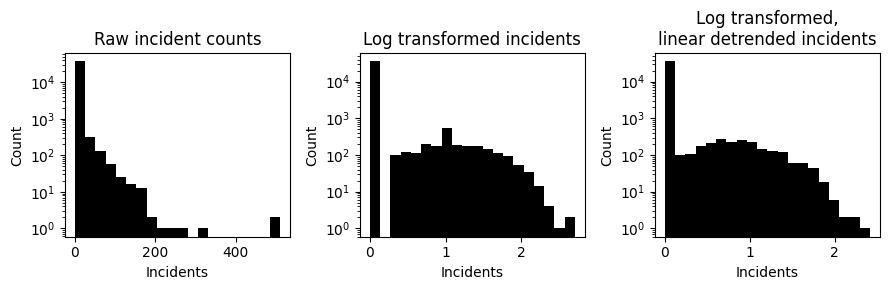

In [38]:
fig, axs=plt.subplots(1,3, figsize=(9,3))
axs=axs.flatten()

axs[0].set_title('Raw incident counts')
axs[0].hist(resampled_working_df['incidents'], bins=20, color='black')
axs[0].set_xlabel('Incidents')
axs[0].set_ylabel('Count')
axs[0].set_yscale('log')

axs[1].set_title('Log transformed incidents')
axs[1].hist(resampled_working_df['log_incidents'], bins=20, color='black')
axs[1].set_xlabel('Incidents')
axs[1].set_ylabel('Count')
axs[1].set_yscale('log')

axs[2].set_title('Log transformed,\nlinear detrended incidents')
axs[2].hist(resampled_working_df['linear_log_incidents'], bins=20, color='black')
axs[2].set_xlabel('Incidents')
axs[2].set_ylabel('Count')
axs[2].set_yscale('log')

plt.tight_layout()
plt.show()

### 10.2. Features time-series plots

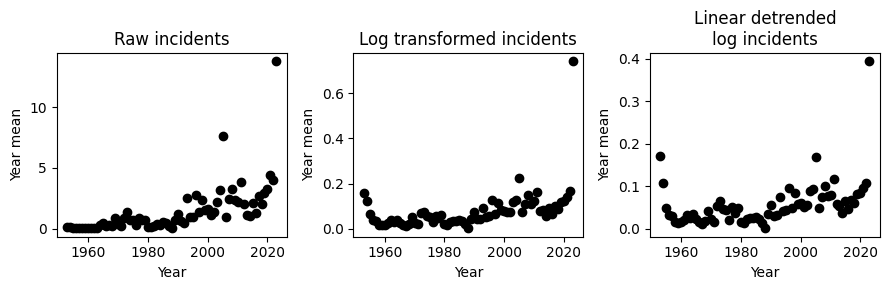

In [39]:
year_means=resampled_working_df.groupby('year').mean()
year_means.head()

fig, axs=plt.subplots(1,3, figsize=(9,3))
axs=axs.flatten()

axs[0].set_title('Raw incidents')
axs[0].scatter(year_means.index, year_means['incidents'], color='black')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Year mean')

axs[1].set_title('Log transformed incidents')
axs[1].scatter(year_means.index, year_means['log_incidents'], color='black')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Year mean')

axs[2].set_title('Linear detrended\nlog incidents')
axs[2].scatter(year_means.index, year_means['linear_log_incidents'], color='black')
axs[2].set_xlabel('Year')
axs[2].set_ylabel('Year mean')

plt.tight_layout()
plt.show()

## 11. Add binary label

In [40]:
# Create binary incident column for labels
resampled_working_df['incidents_binary']=resampled_working_df['incidents'].clip(lower=0, upper=1)
resampled_working_df.head(20)

incidents  log_incidents     month_sin     month_cos  AR  \
year month state                                                             
1953 5     LA             1            1.0  5.000000e-01 -8.660254e-01   0   
     6     LA             0            0.0  1.224647e-16 -1.000000e+00   0   
     7     LA             0            0.0 -5.000000e-01 -8.660254e-01   0   
     8     LA             0            0.0 -8.660254e-01 -5.000000e-01   0   
     9     LA             0            0.0 -1.000000e+00 -1.836970e-16   0   
     10    LA             0            0.0 -8.660254e-01  5.000000e-01   0   
     11    LA             0            0.0 -5.000000e-01  8.660254e-01   0   
     12    LA             0            0.0 -2.449294e-16  1.000000e+00   0   
1954 1     LA             0            0.0  5.000000e-01  8.660254e-01   0   
     2     LA             0            0.0  8.660254e-01  5.000000e-01   0   
     3     LA             0            0.0  1.000000e+00  6.123234e-17   0   
     4     LA             0            0.0  8.660254e-01 -5.000000e-01   0   
     5     LA             0            0.0  5.000000e-01 -8.660254e-01   0   
     6     LA             0            0.0  1.224647e-16 -1.000000e+00   0   
     7     LA             0            0.0 -5.000000e-01 -8.660254e-01   0   
     8     LA             0            0.0 -8.660254e-01 -5.000000e-01   0   
     9     LA             0            0.0 -1.000000e+00 -1.836970e-16   0   
     10    LA             0            0.0 -8.660254e-01  5.000000e-01   0   
     11    LA             0            0.0 -5.000000e-01  8.660254e-01   0   
     12    LA             0            0.0 -2.449294e-16  1.000000e+00   0   

                  AZ  CA  CO  CT  DE  ...  UT  VA  VI  VT  WA  WI  WV  WY  \
year month state                      ...                                   
1953 5     LA      0   0   0   0   0  ...   0   0   0   0   0   0   0   0   
     6     LA      0   0   0   0   0  ...   0   0   0   0   0   0   0   0   
     7     LA      0   0   0   0   0  ...   0   0   0   0   0   0   0   0   
     8     LA      0   0   0   0   0  ...   0   0   0   0   0   0   0   0   
     9     LA      0   0   0   0   0  ...   0   0   0   0   0   0   0   0   
     10    LA      0   0   0   0   0  ...   0   0   0   0   0   0   0   0   
     11    LA      0   0   0   0   0  ...   0   0   0   0   0   0   0   0   
     12    LA      0   0   0   0   0  ...   0   0   0   0   0   0   0   0   
1954 1     LA      0   0   0   0   0  ...   0   0   0   0   0   0   0   0   
     2     LA      0   0   0   0   0  ...   0   0   0   0   0   0   0   0   
     3     LA      0   0   0   0   0  ...   0   0   0   0   0   0   0   0   
     4     LA      0   0   0   0   0  ...   0   0   0   0   0   0   0   0   
     5     LA      0   0   0   0   0  ...   0   0   0   0   0   0   0   0   
     6     LA      0   0   0   0   0  ...   0   0   0   0   0   0   0   0   
     7     LA      0   0   0   0   0  ...   0   0   0   0   0   0   0   0   
     8     LA      0   0   0   0   0  ...   0   0   0   0   0   0   0   0   
     9     LA      0   0   0   0   0  ...   0   0   0   0   0   0   0   0   
     10    LA      0   0   0   0   0  ...   0   0   0   0   0   0   0   0   
     11    LA      0   0   0   0   0  ...   0   0   0   0   0   0   0   0   
     12    LA      0   0   0   0   0  ...   0   0   0   0   0   0   0   0   

                  linear_log_incidents  incidents_binary  
year month state                                          
1953 5     LA                 1.237322                 1  
     6     LA                 0.000000                 0  
     7     LA                 0.000000                 0  
     8     LA                 0.000000                 0  
     9     LA                 0.000000                 0  
     10    LA                 0.000000                 0  
     11    LA                 0.000000                 0  
     12    LA                 0.000000                 0  
1954 1     LA   

## 12. Save

In [41]:
# Save the complete dataset
resampled_working_df.to_parquet('../data/resampled_disaster_data_all.parquet')